In [1]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers "trl<0.9.0" peft accelerate bitsandbytes
!pip install PyMuPDF
!pip install PyPDF2


In [2]:
from unsloth import FastLanguageModel
import torch

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [3]:
import pandas as pd
from google.colab import files
from datasets import Dataset
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported
import matplotlib.pyplot as plt
import json
import time
import os
import io
import fitz  # PyMuPDF
import re

In [4]:
class LanguageModelTrainer:
    def __init__(self):
        self.max_seq_length = 2000
        self.dtype = None
        self.load_in_4bit = True
        self.model = None
        self.tokenizer = None
        self.trainer = None
        self.start_gpu_memory = None
        self.gpu_stats = None
        self.trainer_stats = None

    def download_model(self):
        print(100 * "***")
        print("DOWNLOADING MODEL START")
        # Record the start time
        start_time = time.time()

        self.model, self.tokenizer = FastLanguageModel.from_pretrained(
            model_name = "unsloth/llama-3-8b-Instruct-bnb-4bit",
            max_seq_length = self.max_seq_length,
            dtype = self.dtype,
            load_in_4bit = self.load_in_4bit,
            token = "HUGGING_FACE_TOKEN_REQUIRED_FOR_RESTRICTED_MODEL",
        )

        self.model = FastLanguageModel.get_peft_model(
            self.model,
            r = 16,
            target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
            lora_alpha = 16,
            lora_dropout = 0,
            bias = "none",
            use_gradient_checkpointing = "unsloth",
            random_state = 3407,
            use_rslora = False,
            loftq_config = None,
        )
        # Record the end time
        end_time = time.time()
        duration = end_time-start_time
        print(f"Downloading Duration: {duration:.2f} seconds")
        print("DOWNLOADING MODEL FINISH")
        print(100 * "***")


    def upload_dataset(self):
        print(100 * "***")
        print("Uploading Dataset For Training and Validating")
        uploaded = files.upload()
        train_extraction = 'extract_information_train.json'
        valid_extraction = 'extract_information_val.json'

        data_df = pd.read_json(train_extraction)
        test_df = pd.read_json(valid_extraction)

        data_df = data_df.head(18)
        dataset = Dataset.from_pandas(data_df[['training_text']])
        split_dataset = dataset.train_test_split(test_size=0.2)

        train_dataset = split_dataset['train']
        validation_dataset = split_dataset['test']

        test_data = Dataset.from_pandas(test_df[['validation_text']])
        return train_dataset, validation_dataset

    def train_model(self, train_dataset, validation_dataset):
        print(100 * "***")
        print("Training Model Start")

        start_time = time.time()
        self.trainer = SFTTrainer(
            model = self.model,
            tokenizer = self.tokenizer,
            train_dataset = train_dataset,
            eval_dataset=validation_dataset,
            dataset_text_field = "training_text",
            max_seq_length = self.max_seq_length,
            dataset_num_proc = 2,
            packing = False,
            args = TrainingArguments(
                per_device_train_batch_size = 1,
                gradient_accumulation_steps = 1,
                warmup_steps = 5,
                max_steps = 20,
                learning_rate = 2e-4,
                fp16 = not is_bfloat16_supported(),
                bf16 = is_bfloat16_supported(),
                logging_steps = 1,
                optim = "adamw_8bit",
                weight_decay = 0.01,
                lr_scheduler_type = "linear",
                seed = 3407,
                output_dir = "outputs",
                report_to="tensorboard",
                evaluation_strategy="steps",
                eval_steps=1
            ),
        )

        self.gpu_stats = torch.cuda.get_device_properties(0)
        self.start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
        max_memory = round(self.gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
        print(f"GPU = {self.gpu_stats.name}. Max memory = {max_memory} GB.")
        print(f"{self.start_gpu_memory} GB of memory reserved.")

        self.trainer_stats = self.trainer.train()
        end_time = time.time()
        duration = end_time-start_time
        print(f"Training Duration: {duration:.2f} seconds")
        print(100 * "***")
        print("Training Model Finished")
        #self.show_memory_stats()


    def show_memory_stats(self):
        used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
        used_memory_for_lora = round(used_memory - self.start_gpu_memory, 3)
        used_percentage = round(used_memory / self.gpu_stats.total_memory * 100, 3)
        lora_percentage = round(used_memory_for_lora / self.gpu_stats.total_memory * 100, 3)
        print(f"{self.trainer_stats.metrics['train_runtime']} seconds used for training.")
        print(f"{round(self.trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
        print(f"Peak reserved memory = {used_memory} GB.")
        print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
        print(f"Peak reserved memory % of max memory = {used_percentage} %.")
        print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

    def plot_loss_curve(self):
        log_history = self.trainer.state.log_history
        training_loss = []
        validation_loss = []
        steps = []

        for log in log_history:
            if 'loss' in log:
                training_loss.append(log['loss'])
                steps.append(log['step'])
            if 'eval_loss' in log:
                validation_loss.append(log['eval_loss'])

        min_length = min(len(training_loss), len(validation_loss))
        training_loss = training_loss[:min_length]
        validation_loss = validation_loss[:min_length]
        steps = steps[:min_length]

        plt.figure(figsize=(10, 5))
        plt.plot(steps, training_loss, label='Training Loss', marker='o')
        plt.plot(steps, validation_loss, label='Validation Loss', marker='o')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Steps')
        plt.legend()
        plt.grid(True)
        plt.show()

    def save_model(self):
        self.model.save_pretrained("./model_finetuned_llama3-7B")
        self.tokenizer.save_pretrained("./finetuned_llama3-7B")
        device = torch.device('cuda:0')
        self.model.to(device)
        FastLanguageModel.for_inference(self.model)

    def extract_json_from_text(self, text):
        json_objects = []
        brace_stack = []
        start_idx = None

        for i, char in enumerate(text):
            if char == '{':
                if not brace_stack:
                    start_idx = i
                brace_stack.append(char)
            elif char == '}':
                brace_stack.pop()
                if not brace_stack:
                    json_str = text[start_idx:i+1]
                    try:
                        json_object = json.loads(json_str)
                        json_objects.append(json_object)
                    except json.JSONDecodeError:
                        # If a match isn't valid JSON, skip it
                        continue

        return json_objects[0]

    def extract_text_between_markers(self, pdf_path, markers):
        # Open the PDF file
        doc = fitz.open(pdf_path)
        extracted_text = ""

        # Combine text from all pages
        for page_num in range(len(doc)):
            page = doc.load_page(page_num)
            text = page.get_text()
            extracted_text += text

        # Extract text between markers
        extracted_sections = []
        for marker in markers:
            start_text, end_text = marker
            # Create a regex pattern to match the text between start_text and end_text
            pattern = re.compile(re.escape(start_text) + r'(.*?)' + re.escape(end_text), re.DOTALL)
            matches = pattern.findall(extracted_text)
            for match in matches:
                extracted_sections.append(match.strip())

        return extracted_sections

    def process_pdf_file(self, pdf_folder, markers):
        # Extract the relevant sections and the entire text
        extracted_sections = self.extract_text_between_markers(pdf_folder, markers)

        # Prepare the shortened text with '*' between sections
        shortened_text = ""
        for section in extracted_sections:
            shortened_text += section + "\n\n" + "*" * 50 + "\n\n"
        shortened_text = shortened_text.strip('\n\n' + "*" * 50 + "\n\n")  # Remove the trailing asterisks and new lines
        return shortened_text

    def process_pdf(self):
        print(100 * "***")
        print("Upload PDF File whose information needs to be extracted: ")
        uploaded = files.upload()
        pdf_path = next(iter(uploaded.keys()))

        markers = [
            (
                f"""es mit anderen Produkten zu vergleichen.""",
                """Sie sind im Begriff, ein Produkt zu erwerben, das nicht einfach ist und schwer zu verstehen sein kann."""
            ),
            (
                "ie sich aus dem Basiswert \nergeben.",
                "Die Emittentin kann die Emissionsbe"
            ),
            (
                "ie sich aus dem Basiswert ergeben.",
                "Die Emittentin kann die Emissionsbe"
            )
        ]

        shortened_text = self.process_pdf_file(pdf_path, markers)

        SYSTEM_PROMPT = """
        You are an ASSISTANT who is expert in Information Extraction from a text and putting it in JSON Format in text summarization. Given a text between <original_text> and </original_text>, your task is to accurately extract the specified information without errors between <extracted_information_in_json> and </extracted_information_in_json>. If a specific piece of information is not available, write '-' as values for its key. Do not include any keys that are not listed. For arrays, provide key-value pairs for each element in the array as dictionaries.
        """

        USER_PROMPT = """
        From the provided text, extract the following information in JSON format as key-value pairs. The keys are:
        - isin
        - ermittent_name
        - produkt_name
        - laufzeit_start/Erstellungsdatum
        - bewertungstag
        - zahltag
        - waehrung
        - nominal
        - Basiswert/Underlying
        - Arrays of dictionaries with keys: Datum, Strike (in%)

        The text is delimited by three asterisks (***). Provide the extracted information in JSON format.
        """

        DESCRIPTION_TEMPLATE = f"""
        SYSTEM_PROMPT: {SYSTEM_PROMPT}

        USER_PROMPT: {USER_PROMPT}

        TEXT: ***
        {shortened_text}
        ***

        ASSISTANT: The extracted information required in JSON format is: \n <extracted_information_in_json>
        """

        inputs = self.tokenizer([DESCRIPTION_TEMPLATE], return_tensors = "pt").to("cuda")
        outputs = self.model.generate(**inputs, max_new_tokens = 500, use_cache = True)

        whole_response = self.tokenizer.batch_decode(outputs)[0]
        required_json = self.extract_json_from_text(whole_response)
        print("The required information from given text is: \n")
        print(100 * "***")
        print(json.dumps(required_json, indent=4))


************************************************************************************************************************************************************************************************************************************************************************************************************
DOWNLOADING MODEL START


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Llama patching release 2024.7
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.26.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/131 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.1k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

Unsloth 2024.7 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


DOWNLOADING MODEL FINISH
************************************************************************************************************************************************************************************************************************************************************************************************************
************************************************************************************************************************************************************************************************************************************************************************************************************
Uploading Dataset For Training and Validating


Saving extract_information_train.json to extract_information_train.json
Saving extract_information_val.json to extract_information_val.json
************************************************************************************************************************************************************************************************************************************************************************************************************
Training Model Start


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=2):   0%|          | 0/14 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/4 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


GPU = Tesla T4. Max memory = 14.748 GB.
5.594 GB of memory reserved.


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 14 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 20
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.662000,1.660726
2,1.660000,1.638136
3,1.666200,1.554972
4,1.572100,1.430001
5,1.432700,1.276211
6,1.275200,1.111568
7,1.133800,0.974294
8,0.979500,0.841625
9,0.852900,0.712615
10,0.703400,0.594297


Training Duration: 208.13 seconds
************************************************************************************************************************************************************************************************************************************************************************************************************
Training Model Finished


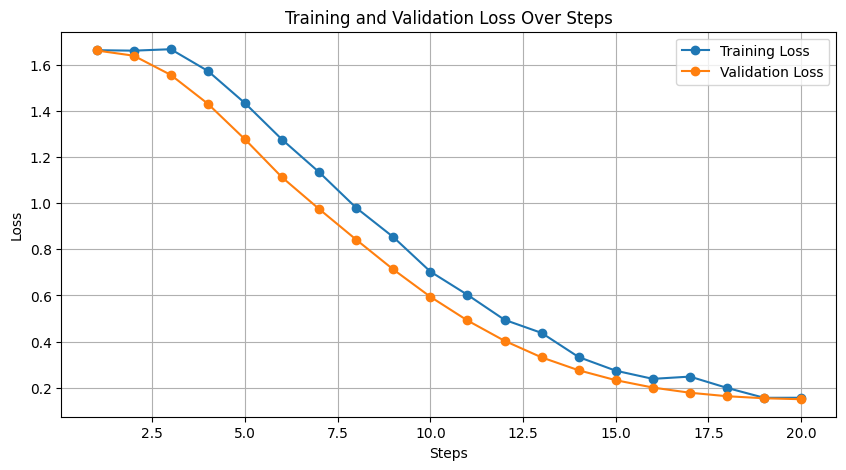

In [5]:
trainer = LanguageModelTrainer()
trainer.download_model()
train_dataset, validation_dataset = trainer.upload_dataset()
trainer.train_model(train_dataset, validation_dataset)
trainer.plot_loss_curve()
trainer.save_model()


In [9]:
trainer.process_pdf()

************************************************************************************************************************************************************************************************************************************************************************************************************
Upload PDF File whose information needs to be extracted: 


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Saving DE000DK07203_Basisinformationsblatt_20230111_172253.pdf to DE000DK07203_Basisinformationsblatt_20230111_172253.pdf
The required information from given text is: 

************************************************************************************************************************************************************************************************************************************************************************************************************
{
    "isin": "DE000DK07203",
    "emittent_name": "DekaBank Deutsche Girozentrale",
    "produkt_name": "Express-Zertifikat Relax 03/2029",
    "laufzeit_start": "2023-01-11",
    "bewertungstag": "2029-03-02",
    "zahltag": "2029-03-09",
    "waehrung": "EUR",
    "nominal": "1000",
    "Basiswert/Underlying": "BASF SE / DE000BASF111",
    "dates_info": [
        {
            "Datum": "2024-03-04 00:00:00",
            "Strike (in %)": "100"
        },
        {
            "Datum": "2025-03-03 00:00:00",
            "St